# CIFAR10 Model Performance Comparison Test

Test Krotov and Hopfield's Bio-Learning Layer Model with and without pruning against a model of the same architecture, but trained using full back propagation to establish a baseline.
Measures to compare:
   * Loss
   * Accuracy

In [183]:
%load_ext autoreload
%autoreload 2

import math
import torch
from torch import nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from pathlib import Path
from context import LocalLearning
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt
import os
import copy
from scipy import stats

plt.style.use(['seaborn-paper', "./PRLDoubleCol.mplstyle"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [176]:
# Path variables
ll_model_path = Path("../data/models/CIFAR10_PowerLaw")
model_path = ll_model_path
figure_path = Path("../data/figures/CIFAR10_PowerLaw")


# Hyper Parameters
BATCH_SIZE = 1000
LEARNING_RATE = 1e-3
NUMBER_OF_EPOCHS = 1000

## Define and Train the Models

Step 1: load the locally learned model

In [4]:
# define file names
fn_ll_model = Path("kh_cifar10.pty")
fn_ll_model_pruned_thr = Path("kh_cifar10_pruned_thr.pty")

# load trained states
ll_trained_state = torch.load(ll_model_path / fn_ll_model)
ll_trained_state_pruned_thr = torch.load(ll_model_path / fn_ll_model_pruned_thr)

In [5]:
# load and configure datasets
ll_layer_pSet = ll_trained_state["model_parameters"]

train_data = LocalLearning.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=True,
    transform=ToTensor(),
    p=ll_layer_pSet["p"],
)

dataloader_train = LocalLearning.DeviceDataLoader(
    train_data,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True,
)

test_data = LocalLearning.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=False,
    transform=ToTensor(),
    p=ll_layer_pSet["p"],
)

dataloader_test = LocalLearning.DeviceDataLoader(
    test_data,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
ll_layer_pSet

{'in_size': 3072,
 'hidden_size': 2000,
 'n': 4.5,
 'p': 3.0,
 'tau_l': 49999.999999999956,
 'k': 2,
 'Delta': 0.4,
 'R': 1.0}

In [65]:
def train(
    trainSet: DataLoader,
    testSet: DataLoader,
    model: LocalLearning.KHModel, 
    loss_fn,
    optimizer,
    learning_rate=None,
    no_epochs=1000,
    checkpt_period=None,
    device=torch.device('cpu'),
    ):
    
    # for scheduling, the learning rate can be a function of the epoch
    if type(learning_rate).__name__ != "function":
        if type(learning_rate).__name__ == "NoneType":
            learning_rate = 1e-3
            
        lr = lambda epoch: learning_rate
        
    else:
        lr = learning_rate
    
    loss_history = [] # loss in each epoch
    score_history = [] # accuracy score in each epoch
    
    with tqdm(range(1, no_epochs + 1), unit="epoch") as tepoch:
        tepoch.set_description(f"Training time [epochs]")
        
        for epoch in tepoch:
            # adjust the learning rate
            optimizer.param_groups[0]['lr'] = lr(epoch)
            
            cumm_loss = 0.0
            model.train()
            for batch_no, (features, labels) in enumerate(trainSet):
                preds = model(features.to(device))
                loss = loss_fn(preds, labels)
                cumm_loss += loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
            loss_history.append(cumm_loss)
            
            freq_correct = 0
            model.eval()
            for batch_no, (features, labels) in enumerate(testSet):
                preds = torch.argmax(model(features), dim=-1)
                freq_correct += (torch.abs(preds - labels) == 0).sum()
            
            score_history.append(freq_correct / (len(testSet)*testSet.batch_size))
            
    return torch.Tensor(loss_history), torch.Tensor(score_history)

## naive way of training the model

In [126]:
# initialize model
khmodel = LocalLearning.KHModel(ll_trained_state)
khmodel.to(device)
khmodel.pSet["n"] = 10

def cross_entropy_loss(outputs, targets):
    # computationally stable
    log_probs = nn.functional.log_softmax(outputs, dim=-1)
    loss = (-log_probs.gather(1, targets[..., None])).sum() / len(outputs)
    
    # Compute negative log likelihood loss
    #loss = nn.functional.nll_loss(log_probs, targets)
    
    return loss

AdamOpt = Adam(khmodel.parameters(), lr=1e-3)

# and train
khmodel.train()
loss_history, score_history = train(
    dataloader_train, 
    dataloader_test, 
    khmodel, 
    cross_entropy_loss, 
    AdamOpt, 
    learning_rate=LEARNING_RATE, 
    no_epochs=10000, 
    device=device,
)

  0%|          | 0/5000 [00:00<?, ?epoch/s]

In [177]:
# save the model
torch.save(
    {
        "fkhl3-path": str(ll_model_path / fn_ll_model),
        "fkhl3-state": ll_trained_state,
        "model_state_dict": khmodel.state_dict(),
        "loss_history": loss_history,
        "accuracy_history": score_history,
    },
    ll_model_path / Path("KHModel.pty"),
)

Text(0, 0.5, 'Accuracy(t)')

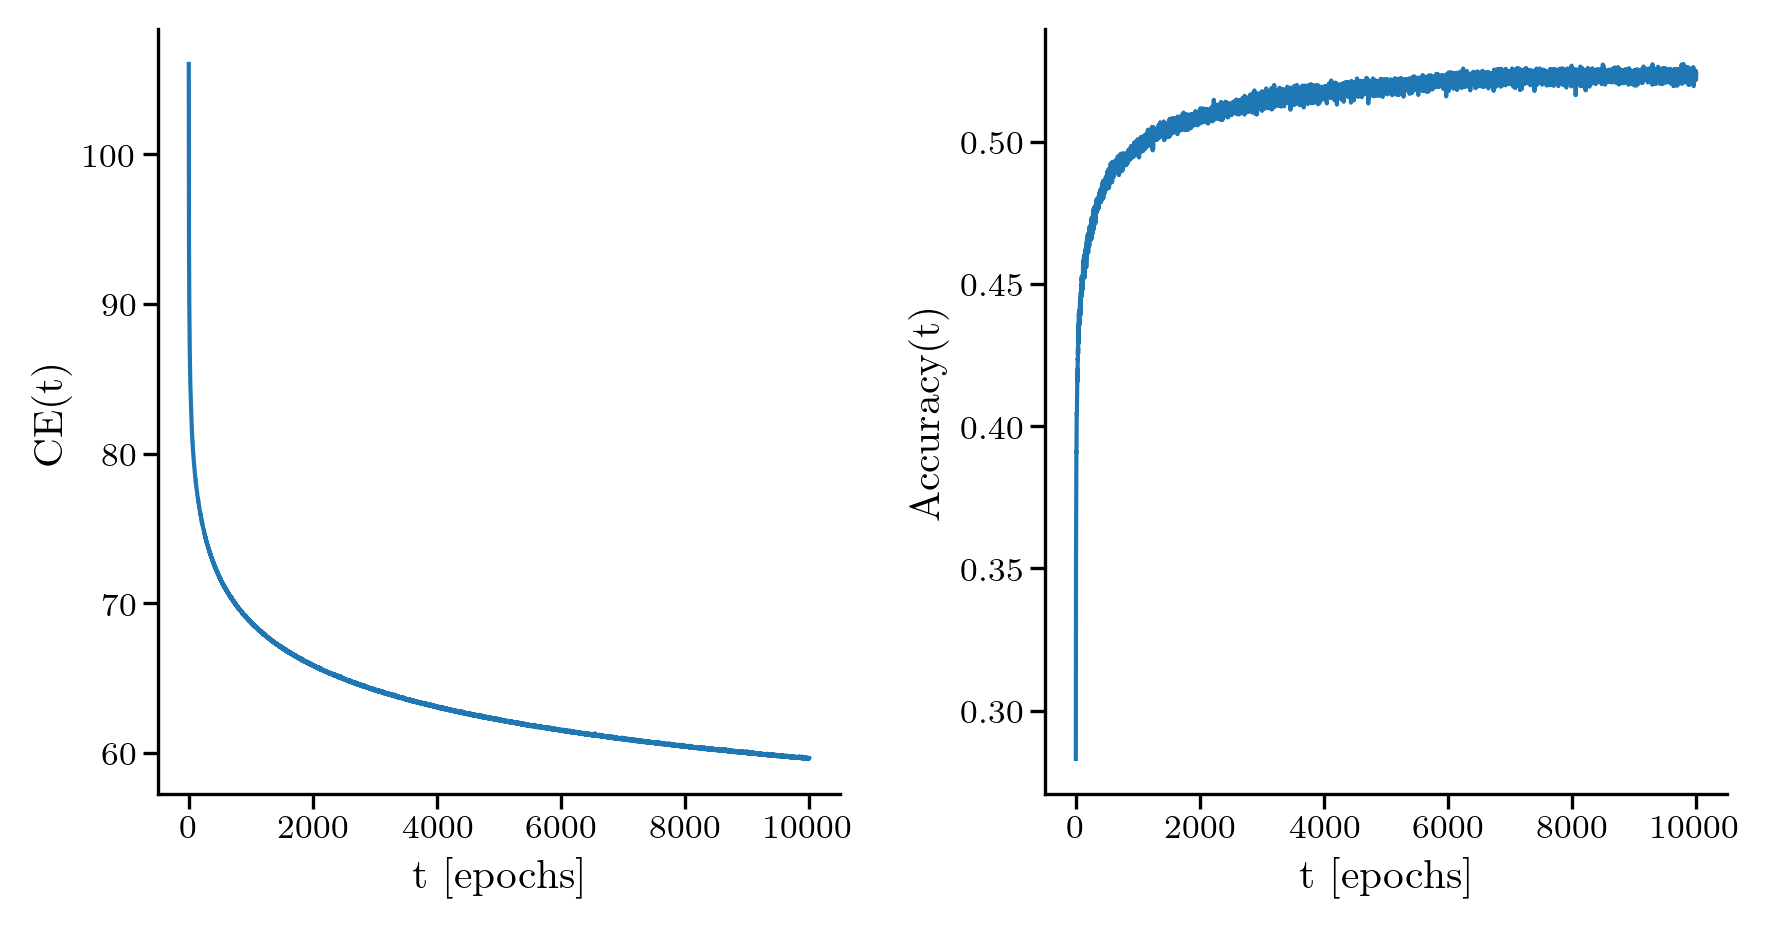

In [139]:
fig, axs = plt.subplots(1, 2)
loss_history_cpu = np.array([a.cpu().detach().numpy() for a in loss_history])
accuracy_history_cpu = np.array([a.cpu().detach().numpy() for a in score_history])
axs[0].plot(loss_history_cpu)
axs[0].set_xlabel(r"t [epochs]")
axs[0].set_ylabel(r"CE(t)")
axs[1].plot(accuracy_history_cpu)
axs[1].set_xlabel(r"t [epochs]")
axs[1].set_ylabel(r"Accuracy(t)")

In [143]:
score_history[-1]

tensor(0.5240)

## Krotov and Hopfields scheduled Method

In [174]:
# initialize model
khmodel_scheduled = LocalLearning.KHModel(ll_trained_state)
khmodel_scheduled.to(device)
khmodel_scheduled.pSet["n"] = 10

AdamOpt = Adam(khmodel_scheduled.parameters(), lr=1e-3)

def khschedule(epoch):
    scale = 2.0
    if epoch <= scale*100:
        return 4e-3
    if (epoch > scale*100) and (epoch <= scale*150):
        return 2e-3
    if (epoch > scale*150) and (epoch <= scale*200):
        return 1e-3
    if (epoch > scale*200) and (epoch <= scale*250):
        return 5e-4
    if (epoch > scale*250) and (epoch <= scale*300):
        return 2e-4
    if (epoch > scale*300) and (epoch <= scale*350):
        return 1e-4
    if (epoch > scale*350) and (epoch <= scale*400):
        return 5e-5
    if (epoch > scale*400) and (epoch <= scale*450):
        return 2e-5
    if (epoch > scale*450) and (epoch <= scale*500):
        return 1e-5
    
#def schedule(epoch):
#    return 4e-3

# and train
khmodel_scheduled.train()
loss_history_scheduled, score_history_scheduled = train(
    dataloader_train, 
    dataloader_test, 
    khmodel_scheduled, 
    cross_entropy_loss, 
    AdamOpt, 
    learning_rate=khschedule, 
    no_epochs=1000, 
    device=device,
)

  0%|          | 0/1000 [00:00<?, ?epoch/s]

In [178]:
# save the model
torch.save(
    {
        "fkhl3-path": str(ll_model_path / fn_ll_model),
        "fkhl3-state": ll_trained_state,
        "model_state_dict": khmodel_scheduled.state_dict(),
        "loss_history": loss_history_scheduled,
        "accuracy_history": score_history_scheduled,
    },
    ll_model_path / Path("KHModel_scheduled.pty"),
)

Text(0, 0.5, 'Accuracy(t)')

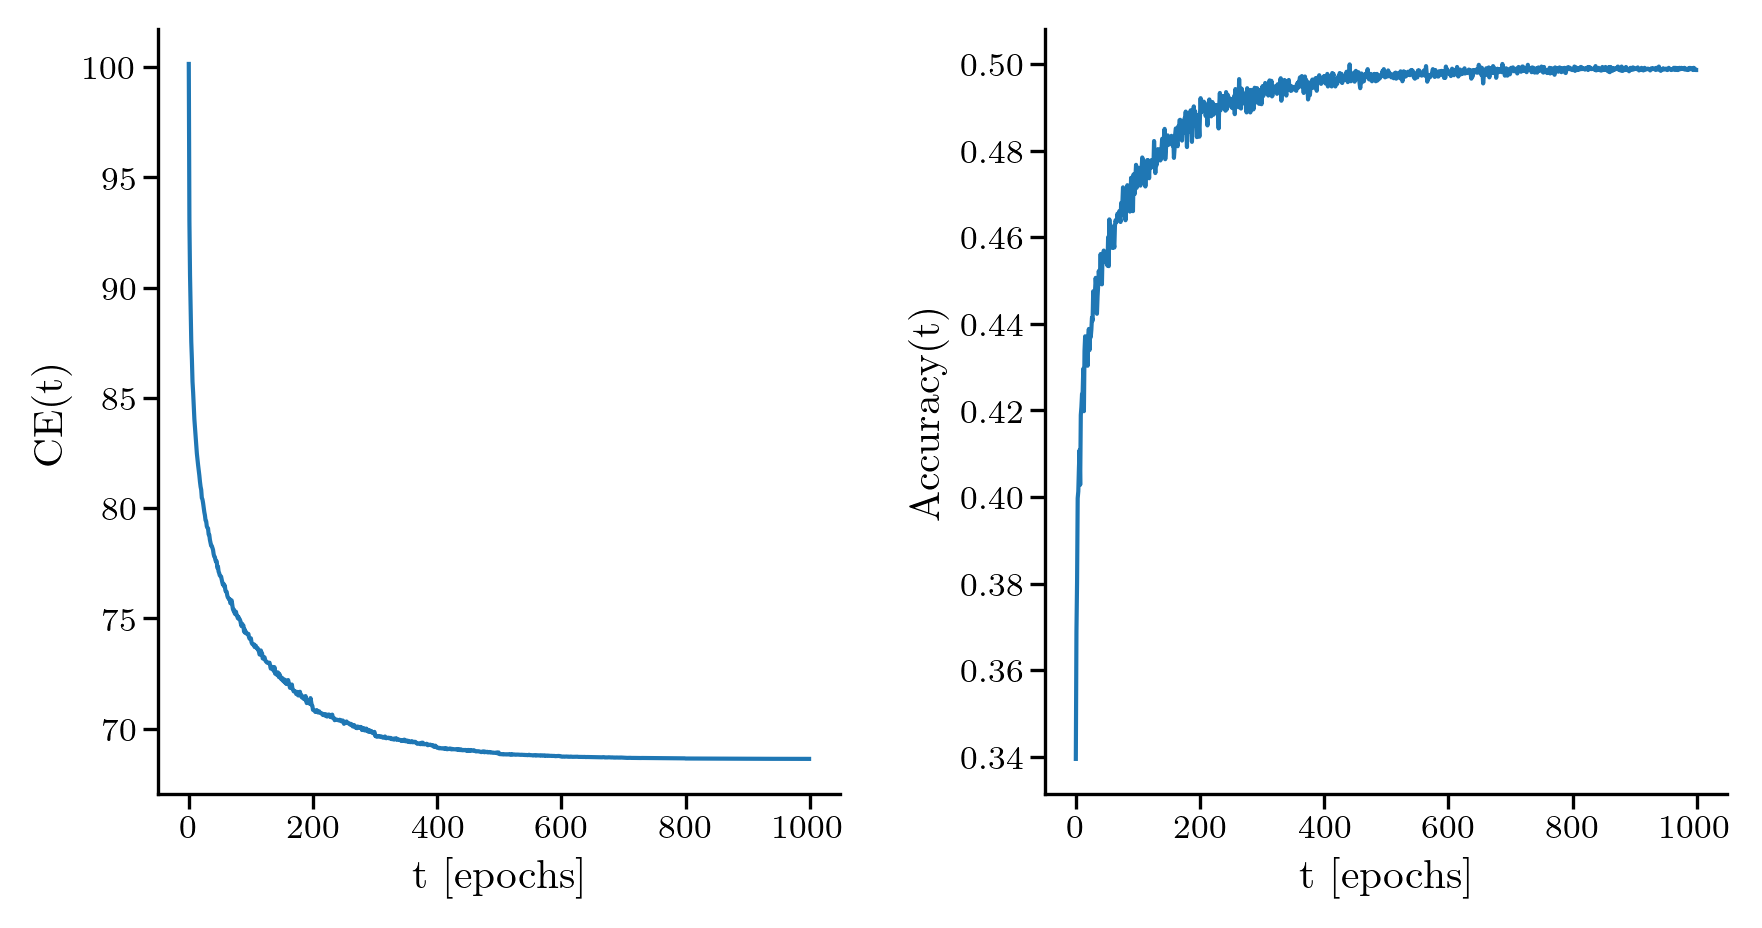

In [175]:
fig, axs = plt.subplots(1, 2)
loss_history_scheduled_cpu = np.array([a.cpu().detach().numpy() for a in loss_history_scheduled])
accuracy_history_scheduled_cpu = np.array([a.cpu().detach().numpy() for a in score_history_scheduled])
axs[0].plot(loss_history_scheduled_cpu)
axs[0].set_xlabel(r"t [epochs]")
axs[0].set_ylabel(r"CE(t)")
axs[1].plot(accuracy_history_scheduled_cpu)
axs[1].set_xlabel(r"t [epochs]")
axs[1].set_ylabel(r"Accuracy(t)")

### Why do we choose n=10 here?

Choosing $n=10$, we get by far the highest accuracy score which correlates with the lowest cross entropy loss. Thus, we choose $n=10$. 

Note, however, that this does not change the training itself, but rather how the locally learned representations perform best.
We should also choose $n=1$ for comparison and do the same analysis, as well as $n=20$.

In [89]:
loss_history[-1]

tensor(68705.3281)

In [90]:
score_history[-1]

tensor(0.4982)

In [87]:
loss_history_scheduled[499]

tensor(71634.7422)

In [88]:
score_history_scheduled[499]

tensor(0.4869)

## Fully Back Prop Model

In [196]:
ann_params = LocalLearning.SHLP.pSet
#ann_params["n"] = khmodel.pSet["n"]
ann_params["n"] = 1
ann = LocalLearning.SHLP(params=ann_params)
ann.to(device)
ann.train()

AdamOpt = Adam(ann.parameters(), lr=1e-3)
ce_loss = nn.CrossEntropyLoss()

def khschedule(epoch):
    if epoch <= 50:
        return 4e-3
    if (epoch <= 60)  and (epoch > 50):
        return 1e-3
    if (epoch <= 70) and (epoch > 60):
        return 5e-4
    if (epoch <= 80) and (epoch > 70):
        return 2e-4
    if (epoch <= 90) and (epoch > 80):
        return 1e-4
    return 1e-5

loss_history_ann, score_history_ann = train(
    dataloader_train, 
    dataloader_test, 
    ann, 
    cross_entropy_loss, 
    AdamOpt, 
    learning_rate=1e-3,#khschedule, 
    no_epochs=200, 
    device=device,
)

  0%|          | 0/200 [00:00<?, ?epoch/s]

Text(0, 0.5, 'Accuracy(t)')

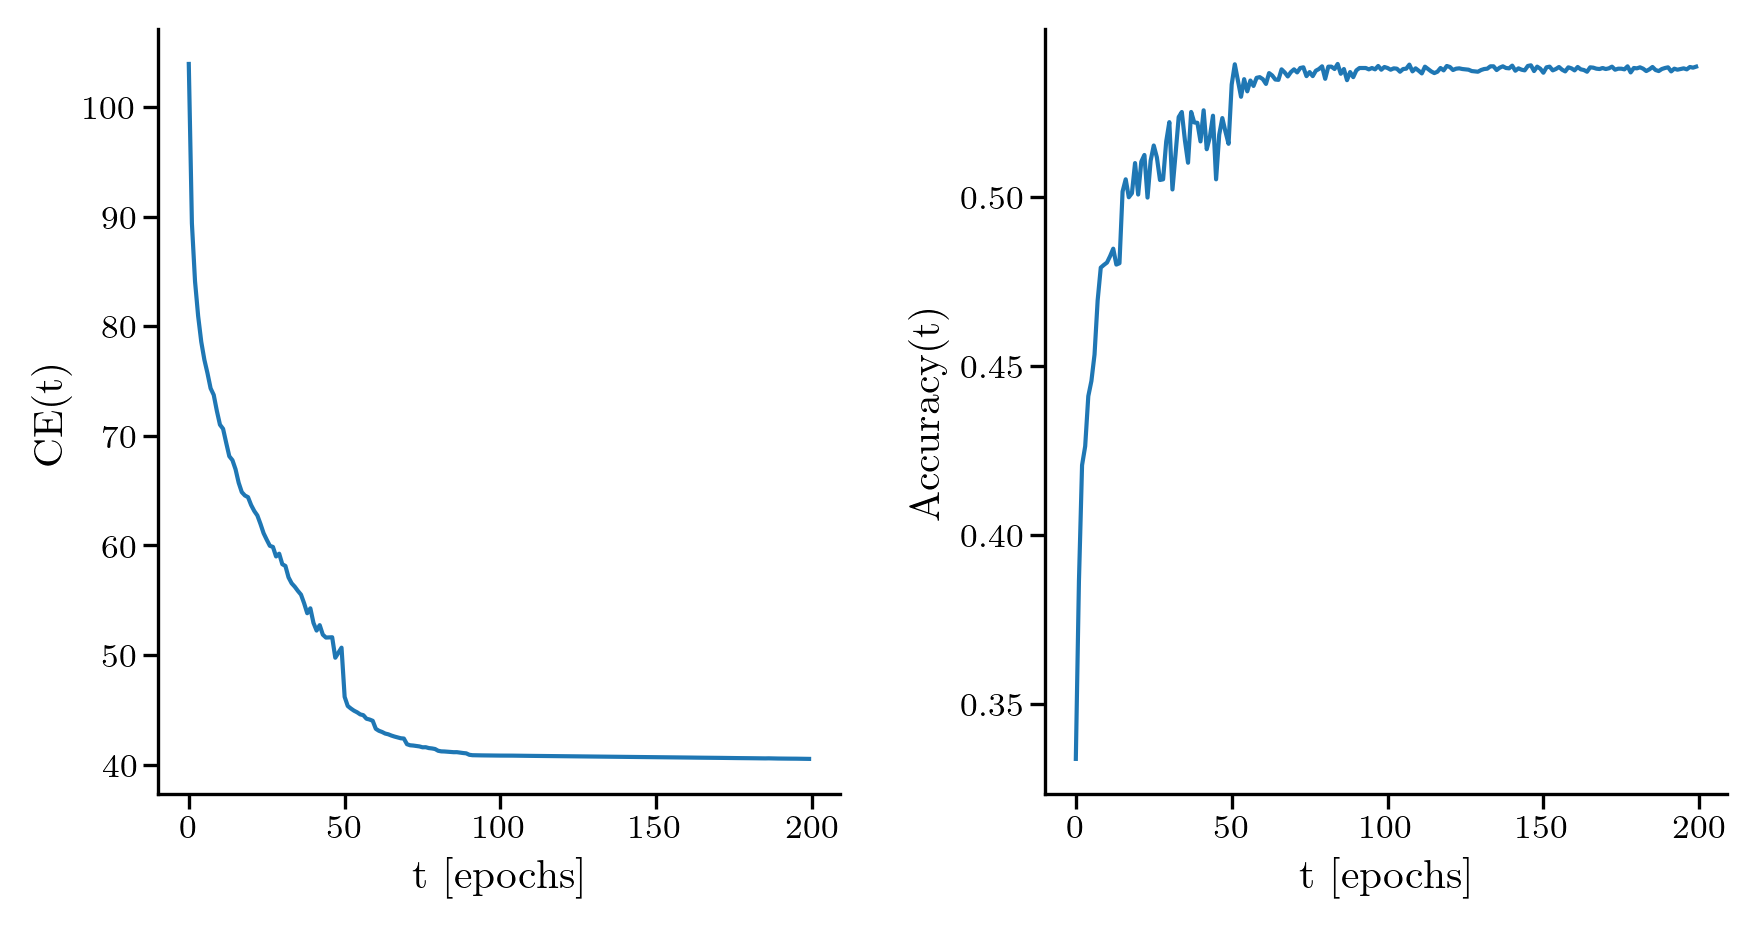

In [193]:
fig, axs = plt.subplots(1, 2)
loss_history_ann_cpu = np.array([a.cpu().detach().numpy() for a in loss_history_ann])
accuracy_history_ann_cpu = np.array([a.cpu().detach().numpy() for a in score_history_ann])
axs[0].plot(loss_history_ann_cpu)
axs[0].set_xlabel(r"t [epochs]")
axs[0].set_ylabel(r"CE(t)")
axs[1].plot(accuracy_history_ann_cpu)
axs[1].set_xlabel(r"t [epochs]")
axs[1].set_ylabel(r"Accuracy(t)")

In [167]:
np.amax(accuracy_history_ann_cpu)

0.5448

In [197]:
# save the model
torch.save(
    {
        "params": ann.pSet,
        "model_state_dict": ann.state_dict(),
        "loss_history": loss_history_ann,
        "accuracy_history": score_history_ann,
    },
    ll_model_path / Path("BPModel.pty"),
)